In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
import os
import csv
from tqdm import tqdm
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


# 데이터 전처리

In [2]:
df = pd.read_csv("data/abalone.csv")
df

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...,...
4172,4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [3]:
df.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
       'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

In [4]:
df['Sex'].value_counts()

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64

문자인 성별 데이터를 정수로 변환

In [5]:
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

In [6]:
df['Sex'].value_counts()

Sex
2    1528
1    1342
0    1307
Name: count, dtype: int64

In [7]:
df

,id,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...,...
4172,4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [8]:
df['Rings'].value_counts()

Rings
9     689
10    634
8     568
11    487
7     391
12    267
6     259
13    203
14    126
5     115
15    103
16     67
17     58
4      57
18     42
19     32
20     26
3      15
21     14
23      9
22      6
27      2
24      2
1       1
26      1
29      1
2       1
25      1
Name: count, dtype: int64

Rings 값을 0에서부터 차례대로 정렬

In [9]:
df['Rings'] = LabelEncoder().fit_transform(df['Rings'])

In [10]:
df['Rings'].value_counts()

Rings
8     689
9     634
7     568
10    487
6     391
11    267
5     259
12    203
13    126
4     115
14    103
15     67
16     58
3      57
17     42
18     32
19     26
2      15
20     14
22      9
21      6
26      2
23      2
0       1
25      1
27      1
1       1
24      1
Name: count, dtype: int64

X, y 설정

In [11]:
X = df.drop('Rings', axis=1).values
y = df['Rings'].values

In [12]:
y = to_categorical(y)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

모델 정의하기

In [15]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,188 (63.23 KB)

 Trainable params: 16,188 (63.23 KB)

 Non-trainable params: 0 (0.00 B)

모델 학습 중 val_accuracy 가 최대일 때의 가중치를 저장

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('data/cnn_abalone_model.keras', save_best_only=True,
                             monitor='val_accuracy', mode='max')

In [18]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1, shuffle=True)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1662 - loss: 2.9138 - val_accuracy: 0.2090 - val_loss: 2.2691
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2220 - loss: 2.3020 - val_accuracy: 0.2537 - val_loss: 2.2034
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2367 - loss: 2.1658 - val_accuracy: 0.2328 - val_loss: 2.1756
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2631 - loss: 2.1437 - val_accuracy: 0.2328 - val_loss: 2.1518
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2459 - loss: 2.1345 - val_accuracy: 0.2119 - val_loss: 2.1420
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2547 - loss: 2.0801 - val_accuracy: 0.2388 - val_loss: 2.1176
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2576 - loss: 2.0526 - val_accuracy: 0.2478 - val_loss: 2.1132
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2630 - loss: 2.0571 - val_accuracy: 0.2239 - val_loss:

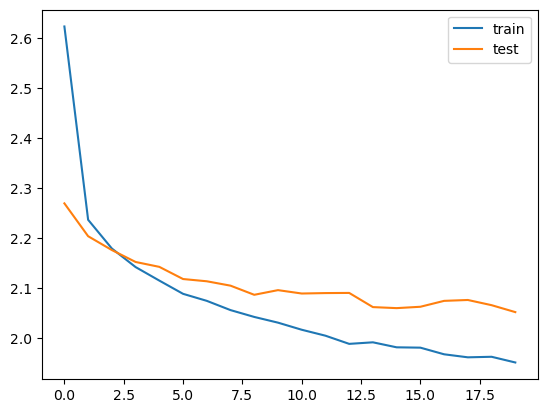

In [19]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()

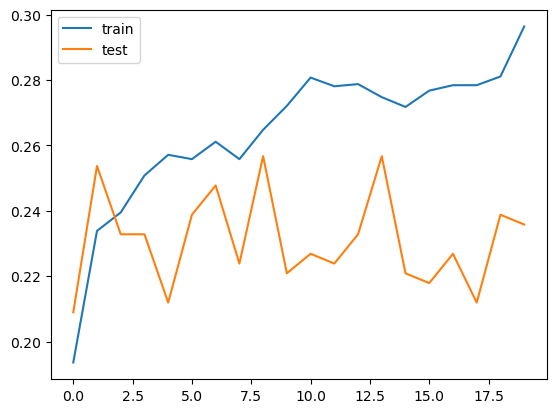

In [20]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="test")
plt.legend()

In [21]:
model.evaluate(X_train, y_train)

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2775 - loss: 1.9252


[1.9426662921905518, 0.28045496344566345]

In [22]:
model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2761 - loss: 1.9739


[1.9731106758117676, 0.28110048174858093]

In [23]:
model.save('data/cnn_abalone_model.keras')


In [24]:
#model_file = 'data/abalone_Model.h5'

#tf.keras.models.save_model(model, model_file, include_optimizer=False)
#print('model saved at ', model_file)

## Pre-trained Model

In [25]:
from tensorflow.keras.models import load_model

base_model = load_model('data/cnn_abalone_model.keras')

In [26]:
base_model.trainable = False

학습률을 낮춰서 학습하면 기존에 학습된 가중치를 지나치게 변경하지 않고 새로운 데이터에 맞춰 미세한 조정이 가능

마지막 출력층을 지우고, 2개의 층을 추가하고 출력층을 추가하여 모델 재학습

In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def remove_last_layers(model, num_layers_to_remove):
    model_layers = model.layers[:-num_layers_to_remove]
    new_model = models.Sequential(model_layers)
    return new_model

new_model = remove_last_layers(base_model, 1)

new_model.add(layers.Dense(256, activation='relu'))
new_model.add(layers.Dense(512, activation='relu'))
new_model.add(layers.Dense(28, activation='softmax'))
new_model.compile(optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'], loss='categorical_crossentropy')

new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,576 (49.12 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,576 (49.12 KB)

In [28]:
import pandas as pd
display_layers = [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<Conv1D name=conv1d, built=True>",conv1d,False
1,"<MaxPooling1D name=max_pooling1d, built=True>",max_pooling1d,False
2,"<Conv1D name=conv1d_1, built=True>",conv1d_1,False
3,"<MaxPooling1D name=max_pooling1d_1, built=True>",max_pooling1d_1,False
4,"<Flatten name=flatten, built=True>",flatten,False
5,"<Dense name=dense, built=True>",dense,False
6,"<Dense name=dense_2, built=False>",dense_2,True
7,"<Dense name=dense_3, built=False>",dense_3,True
8,"<Dense name=dense_4, built=False>",dense_4,True


In [29]:
history1 = new_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1,
                         shuffle=True)
new_model.summary()

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0679 - loss: 3.2640 - val_accuracy: 0.1373 - val_loss: 3.0843
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1310 - loss: 3.0632 - val_accuracy: 0.1791 - val_loss: 2.9042
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1759 - loss: 2.8989 - val_accuracy: 0.2328 - val_loss: 2.7419
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2022 - loss: 2.7311 - val_accuracy: 0.2149 - val_loss: 2.5998
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2325 - loss: 2.5849 - val_accuracy: 0.2149 - val_loss: 2.4860
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2428 - loss: 2.4610 - val_accuracy: 0.2328 - val_loss: 2.4016
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2438 - loss: 2.4072 - val_accuracy: 0.2239 - val_loss: 2.3385
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2425 - loss: 2.3129 - val_accuracy: 0.2239 - val_loss:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,494 (2.10 MB)

 Trainable params: 178,972 (699.11 KB)

 Non-trainable params: 12,576 (49.12 KB)

 Optimizer params: 357,946 (1.37 MB)

In [30]:
new_model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2474 - loss: 2.1174


[2.080695629119873, 0.2667464017868042]

## FineTunning

In [31]:
base_model.trainable = True
new_model.compile(optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'], loss='categorical_crossentropy')

In [32]:
import pandas as pd
display_layers = [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<Conv1D name=conv1d, built=True>",conv1d,True
1,"<MaxPooling1D name=max_pooling1d, built=True>",max_pooling1d,True
2,"<Conv1D name=conv1d_1, built=True>",conv1d_1,True
3,"<MaxPooling1D name=max_pooling1d_1, built=True>",max_pooling1d_1,True
4,"<Flatten name=flatten, built=True>",flatten,True
5,"<Dense name=dense, built=True>",dense,True
6,"<Dense name=dense_2, built=True>",dense_2,True
7,"<Dense name=dense_3, built=True>",dense_3,True
8,"<Dense name=dense_4, built=True>",dense_4,True


In [33]:
history1 = new_model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_split = 0.1, shuffle = True)

new_model.summary()

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2551 - loss: 2.0593 - val_accuracy: 0.2060 - val_loss: 2.0997
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2676 - loss: 2.0301 - val_accuracy: 0.2090 - val_loss: 2.0941
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2659 - loss: 2.0339 - val_accuracy: 0.2060 - val_loss: 2.0882
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2633 - loss: 2.0771 - val_accuracy: 0.2090 - val_loss: 2.0838
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2680 - loss: 2.0399 - val_accuracy: 0.2119 - val_loss: 2.0797
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2779 - loss: 2.0328 - val_accuracy: 0.2090 - val_loss: 2.0764
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2760 - loss: 2.0491 - val_accuracy: 0.2149 - val_loss: 2.0718
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2804 - loss: 2.0424 - val_accuracy: 0.2119 - val_loss:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 28)             │        14,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,646 (2.19 MB)

 Trainable params: 191,548 (748.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 383,098 (1.46 MB)

In [34]:
new_model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2877 - loss: 2.0214


[1.9999151229858398, 0.29425838589668274]

기존 모델을 불러와 학습 및 조정할 때, 학습률을 낮추는 것이 유의미하게 상승하는 것을 알 수 있었다.